# Description of Script
This script creates the visit features using the clinic data and explores the clinic data

**Author:** Marang Mutloatse

**Version:** 0.0.1

**State:** Development

## Import Libraries

In [3]:
import pandas as pd
import datetime as dt
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import os
user_dev_path = os.path.dirname(os.getcwd())
# get parent path for package
package_path = os.path.dirname(user_dev_path)
import sys
sys.path.insert(0,package_path + '/src/')
import yaml
from datetime import timedelta
from hiv_support_package import visit_features,target_creation
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
start_date = '2015-01-01 00:00:00'
LAST_EXPECTED_VISIT = '2020-12-31 00:00:00' 

## Working Functions

In [5]:
def load_excel_sheet(path: str):
    if path is not None:
        try:
            xls = pd.ExcelFile(path)
            df = xls.parse(skiprows=0)
            return df
        except Exception as e:
            print(f"Exception on loading excel spreadsheet with error: {e}")

def convert_to_datetime(df,date_col: str):
    if df is not None:
        try:
            df[date_col] = pd.to_datetime(df[date_col],errors='coerce')
            return df
        except Exception as e:
            print(f"Exception on converting to datetime with error: {e}") 
            
def print_num_rows_cols(df, df_name: str):
        if df is not None:
            return print(f"{df_name} data has {df.shape[1]} columns and {df.shape[0]} rows.") 

def check_null_values(df):
    if df is not None:
        try:
            missing_value = df.isnull().sum()
            mis_val_percent = 100 * df.isnull().sum() / len(df)
            mis_val_table = pd.concat([missing_value, mis_val_percent], axis=1)
            mis_val_table_rename_cols = mis_val_table.rename(
                columns={0: "Missing Values", 1: "% of Total Values"}
            )
            mis_val_table_rename_cols = (
                mis_val_table_rename_cols[mis_val_table_rename_cols.iloc[:, 1] != 0]
                .sort_values("% of Total Values", ascending=False)
                .round(1)
            )
            print(
                "There are "
                + str(mis_val_table_rename_cols.shape[0])
                + " columns that have missing values"
            )
            return mis_val_table_rename_cols
        except Exception as e:
            print(f"Exception on checking missing values with error: {e}")

def under_represented(df, threshold=0.99):
    under_rep = []
    for column in df:
        counts = df[column].value_counts()
        majority_freq = counts.iloc[0]
        if (majority_freq / len(df)) > threshold:
            under_rep.append(column)
        if not under_rep:
            print("No underrepresented features")
        else:
            if TARGET in under_rep:
                print("The target variable is underrepresented, consider rebalancing")
                under_rep.remove(TARGET)
            print(str(under_rep) + " underrepresented")
        return under_rep

def categorical_bar_plot(df):
    if df is not None:
        for i in df.columns[df.dtypes==object]:
            df[i].value_counts().plot(kind='bar')
            plt.title(i)
            plt.show()
            
def plot_line_graph(df,x_variable: str,y_variable: str,x_label: str,y_label: str):
    ax = sns.lineplot(x = x_variable,y=y_variable,data=df)
    ax.set(xlabel=x_label, ylabel=y_label)
    ax.set_title('Comparison Plot: Trend of Average Monthly LTFU')
    plt.xticks(rotation=60)
    plt.legend(loc='upper left')
    sns.set(rc={'figure.figsize':(10,10)})

def plot_boxplot_graph(df,x_variable: str,y_variable: str,x_label: str,y_label: str,title: str,hue=None):
    ax = sns.boxplot(x = x_variable,y=y_variable,data=df,hue=None)
    ax.set(xlabel=x_label, ylabel=y_label)
    ax.set_title(title)
    plt.xticks(rotation=60)
    plt.legend(loc='upper left')
    sns.set(rc={'figure.figsize':(10,10)})

## Import Data

In [6]:
try: 
    with open (user_dev_path + '/' + 'config_LTFU.yaml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print(f'Error reading the config file, {e}')

In [7]:
# Get File paths and file names
input_root = config['rise_files']['raw_data_path']
clinic_file = config['rise_files']['raw_clinic_file']
otz_file = config['rise_files']['raw_otz_file']

# paths
clinic_input = input_root + clinic_file
print(clinic_input)

/data/rise_data/ClinicData.xlsx


In [5]:
# load dataframe
df = load_excel_sheet(clinic_input)

## Data Description and Verification

In [6]:
print_num_rows_cols(df,'Clinic')

Clinic data has 38 columns and 924862 rows.


In [7]:
pd.set_option('display.max_columns', 500)
df = df.sort_values(by=['PATIENT_ID','DATE_VISIT'])

In [8]:
mapping_dict = {'name':'State','name.1':'L.G.A','name.2':'Facility Name'}
df.rename(columns=mapping_dict, inplace=True)

### Data Cleaning

In [9]:
print("Shape before cleaning by date: ")
print_num_rows_cols(df,'Clinic')

date_cols = ['DATE_VISIT','NEXT_APPOINTMENT']

df['DATE_VISIT'] = pd.to_datetime(df['DATE_VISIT'], errors='coerce')
df['NEXT_APPOINTMENT'] = pd.to_datetime(df['NEXT_APPOINTMENT'], errors='coerce')

df = df.loc[(df['DATE_VISIT'] >= '1998-01-01 00:00:00') & (df['DATE_VISIT'] <= '2020-12-31 00:00:00')]

print(" ")
print("Shape after limiting by date: ")
print_num_rows_cols(df,'Clinic')

Shape before cleaning by date: 
Clinic data has 38 columns and 924862 rows.
 
Shape after limiting by date: 
Clinic data has 38 columns and 867552 rows.


**Checking Duplicate Values**

In [10]:
df.duplicated().sum()

0

In [11]:
print(f"There are {df.loc[:, df.columns != 'CLINIC_ID'].duplicated(subset=['DATE_VISIT','PATIENT_ID','FACILITY_ID'],keep='last').sum()} duplicate rows based on the Facility, Patient ID and Visit Date")

There are 4751 duplicate rows based on the Facility, Patient ID and Visit Date


In [12]:
df_new = df[df.loc[:, df.columns != 'CLINIC_ID'].duplicated(subset=['PATIENT_ID','DATE_VISIT','FACILITY_ID'])].sort_values(['PATIENT_ID','DATE_VISIT'])

In [13]:
print(f"Before deduplication the dataframe has {df.shape[0]} rows")
print(" ")
df.drop_duplicates(subset=['PATIENT_ID','DATE_VISIT','FACILITY_ID'],inplace=True)
print(f"After deduplication the dataframe has {df.shape[0]} rows")

Before deduplication the dataframe has 867552 rows
 
After deduplication the dataframe has 862801 rows


**Checking missing values**

In [14]:
check_null_values(df)

There are 22 columns that have missing values


Missing Values  % of Total Values
covid_confirmed               862801              100.0
GESTATIONAL_AGE               862801              100.0
STI_IDS                       862801              100.0
STI_TREATED                   862801              100.0
date_covid_confirmed          862801              100.0
ADR_IDS                       862749              100.0
OI_IDS                        861861               99.9
ADHERE_IDS                    861375               99.8
LMP                           859969               99.7
MATERNAL_STATUS_ART           855266               99.1
offered_index                 829500               96.1
REGIMEN                       724651               84.0
REGIMENTYPE                   724554               84.0
NOTES                         699089               81.0
BP                            432118               50.1
ADR_SCREENED                  367433               42.6
OI_SCREENED                   365761               42.4
ADHERENCE_LEVEL               359930               41.7
CLINIC_STAGE                  187615               21.7
tb_status                      60753                7.0
func_status                    28114                3.3
NEXT_APPOINTMENT               25635                3.0

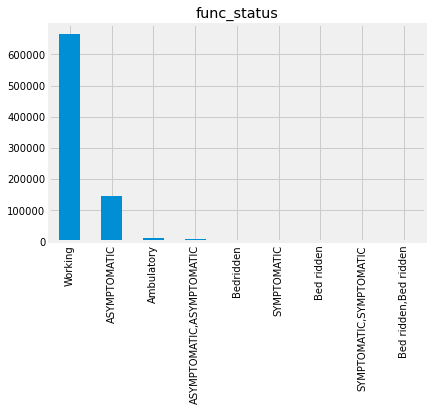

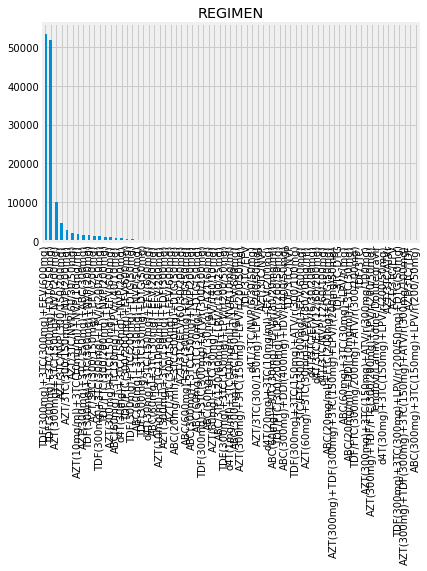

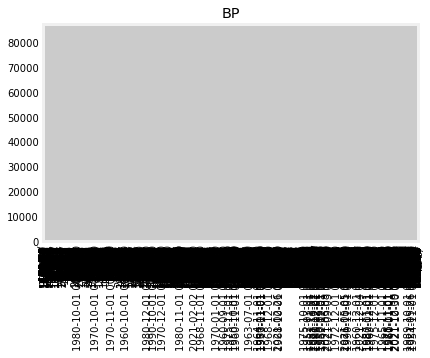

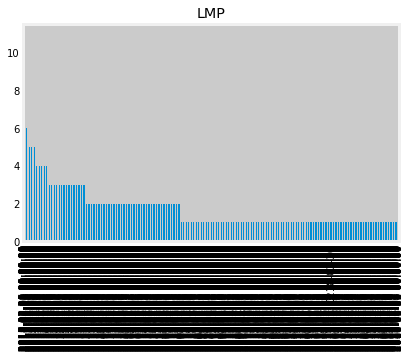

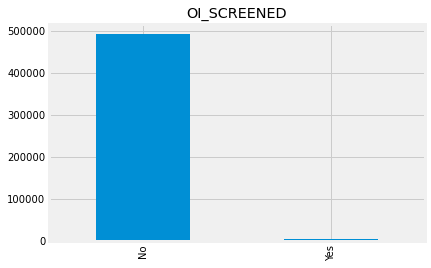

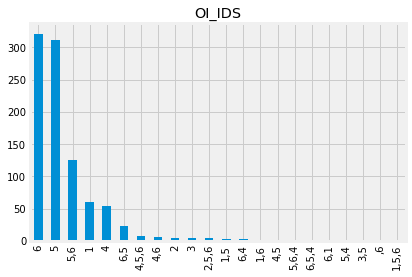

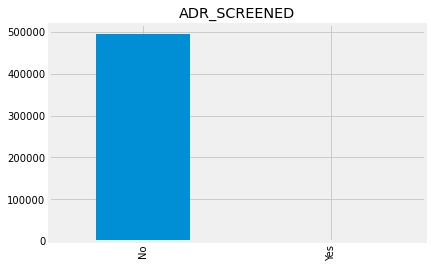

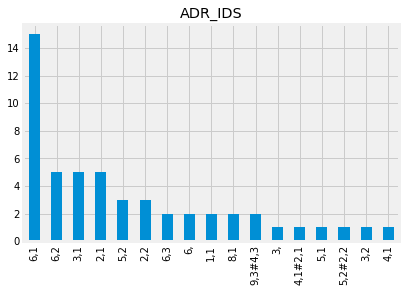

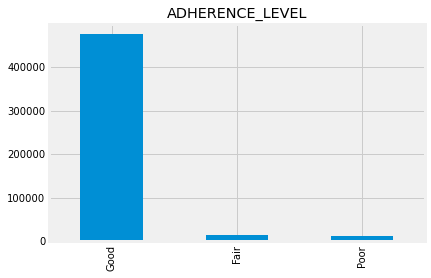

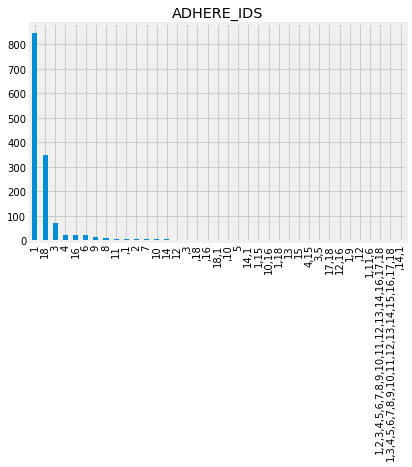

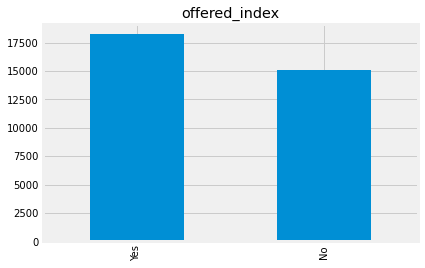

/anaconda/envs/py38_default/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda/envs/py38_default/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


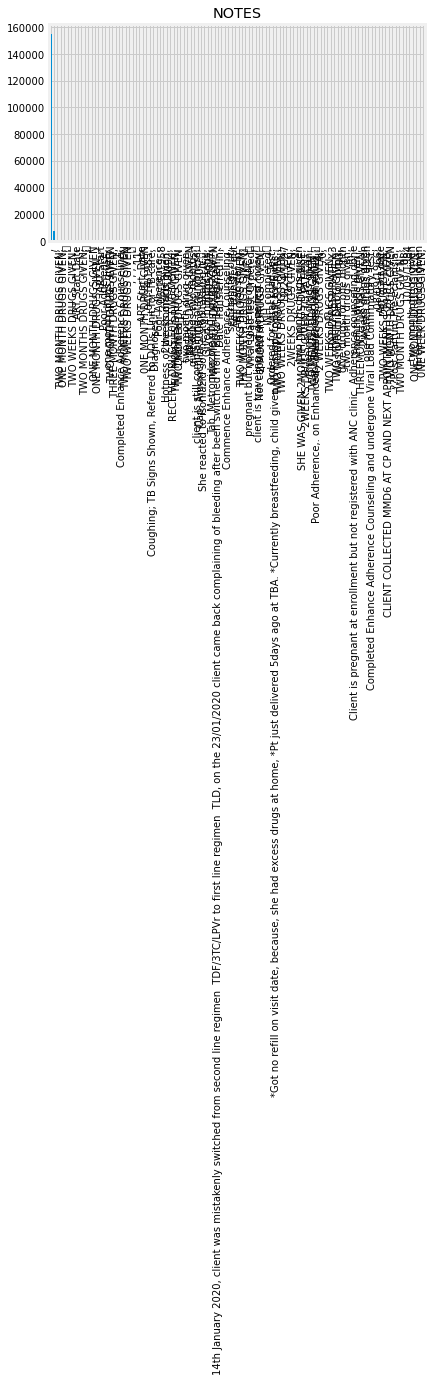

In [15]:
categorical_bar_plot(df)

In [16]:
under_represented(df, threshold=0.90)

No underrepresented features


[]

In [17]:
print(df.DATE_VISIT.head(3))
(df.DATE_VISIT+ timedelta(days=-1)).head(3)

0        2020-06-06
698996   2020-09-06
24       2020-02-19
Name: DATE_VISIT, dtype: datetime64[ns]


0        2020-06-05
698996   2020-09-05
24       2020-02-18
Name: DATE_VISIT, dtype: datetime64[ns]

In [18]:
(df.DATE_VISIT+ timedelta(days=-1)).head(3)

0        2020-06-05
698996   2020-09-05
24       2020-02-18
Name: DATE_VISIT, dtype: datetime64[ns]

In [19]:
df = df[~df['DATE_VISIT'].isnull()]
print("df with all next appointments:",df.shape)
df.loc[df['NEXT_APPOINTMENT'].isnull(),'NEXT_APPOINTMENT'] = df.DATE_VISIT+ timedelta(days=-1)
print("df with NULL next appointments filled:",df.shape)

df with all next appointments: (862801, 38)
df with NULL next appointments filled: (862801, 38)


In [20]:
print("PATIENT_ID: " + "{:,}".format(df.PATIENT_ID.nunique()))

PATIENT_ID: 123,605


In [21]:
drop_cols = ['covid_confirmed','GESTATIONAL_AGE','STI_TREATED','STI_IDS','date_covid_confirmed','ADHERE_IDS','ADR_IDS','OI_IDS','LMP','MATERNAL_STATUS_ART']

# Data Transformation

## Stats on dates for target definition

In [22]:
 df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] = (df['NEXT_APPOINTMENT'] - df['DATE_VISIT']).dt.days

In [23]:
median_days_to_next_appointment = df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'].median()
print("median_days_to_next_appointment:",median_days_to_next_appointment)

median_days_to_next_appointment: 45.0


In [24]:
print("Shape before deduplication by date: ")
print_num_rows_cols(df,'Clinic')
df.drop_duplicates(keep='last', inplace = True)
print(" ")
print("Shape after deduplication by date: ")
print_num_rows_cols(df,'Clinic')

Shape before deduplication by date: 
Clinic data has 39 columns and 862801 rows.
 
Shape after deduplication by date: 
Clinic data has 39 columns and 862801 rows.


## Date Featurization

In [25]:
df = visit_features.generate_date_features(df,'DATE_VISIT')
df = visit_features.generate_date_features(df,'NEXT_APPOINTMENT')

Generating features for DATE_VISIT, starting with  rows:862,801; cols: 39
Generating features for DATE_VISIT,ending with  rows:862,801; cols: 49
Generating features for NEXT_APPOINTMENT, starting with  rows:862,801; cols: 49
Generating features for NEXT_APPOINTMENT,ending with  rows:862,801; cols: 59


In [26]:
df.EF_YEAR_DATE_VISIT.value_counts().sort_index()

2000        18
2001        38
2002        85
2003        21
2004        25
2005        85
2006       530
2007      2056
2008      4542
2009      8385
2010     10231
2011     15303
2012     20589
2013     27551
2014     34941
2015     53260
2016     75658
2017    116243
2018    128574
2019    176499
2020    188167
Name: EF_YEAR_DATE_VISIT, dtype: int64

In [27]:
 df['EF_FIRST_DATE_VISIT'] = df.groupby('PATIENT_ID')['DATE_VISIT'].transform('min')

In [28]:
# generate sequence based off merged ID
df['EF_ID_SEQUENCE'] = df.groupby('PATIENT_ID').cumcount() + 1

In [29]:
df.EF_ID_SEQUENCE.head()

0         1
698996    2
24        1
881907    2
881897    3
Name: EF_ID_SEQUENCE, dtype: int64

In [30]:
 df['EF_FIRST_DATE_VISIT'].min() 

Timestamp('2000-01-23 00:00:00')

In [31]:
df = df.loc[(df['EF_FIRST_DATE_VISIT'] >= start_date)]
print("Shape after filtering early starters before: ", start_date, visit_features.format_shape(df))

Shape after filtering early starters before:  2015-01-01 00:00:00 rows:484,300; cols: 61


In [32]:
df['EF_MONTH_UNIQUE'] = df['EF_YEAR_DATE_VISIT'].apply(str)+'-'+df['EF_MONTH_DATE_VISIT'].apply(str)

## Level of Aggregation for Visits

In [33]:
df['FACILITY_ID'].value_counts().to_frame()

FACILITY_ID
459         58823
614         34372
505         23156
562         22477
2881        21576
...           ...
630            60
496            43
3088           36
3091           20
2886            8

[101 rows x 1 columns]

In [34]:
df['Facility Name'].value_counts()

Ukpom Abak General Hospital              58823
Ikot Ekpene Primary Health Centre        34372
Ukana Cottage Hospital                   23156
Ibiono Handmaids Hospital                22477
Numan General Hospital                   21576
                                         ...  
Ikot Andem Itam Primary Health Centre       60
Ekpenyong 1 Midim Atan Health Centre        43
Usuk Ibakasi Primary Health Centre          36
Iwerre Health Centre                        20
Cottage Hospital Gulak                       8
Name: Facility Name, Length: 101, dtype: int64

In [35]:
df['L.G.A'].value_counts()

Abak           87293
Ikot Ekpene    68378
Essien Udim    39237
Ibiono-Ibom    34543
Ogoja          31853
Numan          21576
Obudu          19551
Itu            18852
Etim Ekpo      15949
Bida           15922
Kontagora      11894
Ini             8351
Lapai           8232
Borgu           8230
Mubi South      8074
Obot Akara      7783
Yala            7409
Gayuk           7302
Ikono           6914
Mokwa           6623
Ika             6306
Song            5962
Shiroro         5689
Hong            5264
Rafi            4923
Wushishi        4602
Obanliku        4140
Rijau           3772
Lavun           2429
Magama          2094
Michika         1625
Girei           1428
Munya            575
Maiha            510
Mariga           430
Demsa            407
Mashegu          170
Madagali           8
Name: L.G.A, dtype: int64

## Days since Last Visit

In [36]:
df = visit_features.days_months_since_visit_features(df)

In [37]:
df = df.rename(columns={'NEXT_APPOINTMENT': 'EF_NEXT_APPOINTMENT'})

In [38]:
df[['PATIENT_ID','DATE_VISIT','EF_NEXT_APPOINTMENT',
    'EF_DAYS_UNTIL_NEXT_APPOINTMENT']].sample(5)

PATIENT_ID DATE_VISIT EF_NEXT_APPOINTMENT  \
310627       65478 2019-10-09          2019-03-07   
73182        19964 2018-10-06          2018-11-05   
730100       61262 2019-06-24          2019-07-22   
296417       63109 2018-06-18          2018-08-15   
897712       57152 2020-09-18          2020-12-21   

        EF_DAYS_UNTIL_NEXT_APPOINTMENT  
310627                            -216  
73182                               30  
730100                              28  
296417                              58  
897712                              94

In [39]:
df['EF_NEXT_APPOINTMENT'].isnull().sum() 

0

## Binning: Appointment Date

In [40]:
bins_NextAppDays = [-100,-2,0,1,32,100,420,10000]
a = df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'].value_counts(bins=bins_NextAppDays).sort_index()
b = df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'].value_counts(bins=bins_NextAppDays, 
                                                          normalize=True).sort_index()
b = (b*100).round(0)
pd.concat([a,b], axis=1)

EF_DAYS_UNTIL_NEXT_APPOINTMENT  \
(-100.001, -2.0]                             771   
(-2.0, 0.0]                                11403   
(0.0, 1.0]                                   331   
(1.0, 32.0]                               196772   
(32.0, 100.0]                             212382   
(100.0, 420.0]                             59298   
(420.0, 10000.0]                            1960   

                  EF_DAYS_UNTIL_NEXT_APPOINTMENT  
(-100.001, -2.0]                             0.0  
(-2.0, 0.0]                                  2.0  
(0.0, 1.0]                                   0.0  
(1.0, 32.0]                                 41.0  
(32.0, 100.0]                               44.0  
(100.0, 420.0]                              12.0  
(420.0, 10000.0]                             0.0

In [41]:
print("All: "+ format(len(df.index), ','))

print("More than 1 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] > 1].index), ','))
print("More than 32 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] > 32].index), ','))
print("More than 100 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] > 100].index), ','))
print("More than 420 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT']> 420].index), ','))

print("Less than 1 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 1].index), ','))
print("Less than 10 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 10].index), ','))
print("Less than 32 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 32].index), ','))
print("Less than 100 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 100].index),','))
print("Less than 420 days: "+ format(len(df[df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 420].index),','))

All: 484,300
More than 1 days: 470,479
More than 32 days: 273,707
More than 100 days: 61,325
More than 420 days: 2,027
Less than 1 days: 13,490
Less than 10 days: 15,638
Less than 32 days: 207,466
Less than 100 days: 422,802
Less than 420 days: 482,243


### Outlier Filtration

In [42]:
print("Incl. bad next appointment dates: "+ format(len(df.index), ','))
# exclude outliers - more than 14 monthsprint("Exclude bad next appointment dates: "+ format(len(df.index), ','))
df = df[(df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] > 1) & 
        (df['EF_DAYS_UNTIL_NEXT_APPOINTMENT'] < 420)]

print("Excl. bad next appointment dates: "+ format(len(df.index), ','))

Incl. bad next appointment dates: 484,300
Excl. bad next appointment dates: 468,422


In [43]:
df = visit_features.next_actual_visit_features(df)

# Target Creation

In [44]:
## Working
df = target_creation.missed_visit_target(df,LAST_EXPECTED_VISIT)
df = target_creation.next_visit_target(df,LAST_EXPECTED_VISIT)
df = target_creation.last_visit_target(df,LAST_EXPECTED_VISIT)

## Binning: Missed Next  Visit

In [45]:
# check group by clinic_id is correct
print(df.groupby('T_MISSED_NEXT_VISIT_28')['CLINIC_ID'].nunique())
df['T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True)

T_MISSED_NEXT_VISIT_28
False    340799
True     127623
Name: CLINIC_ID, dtype: int64


False    0.727547
True     0.272453
Name: T_MISSED_NEXT_VISIT_28, dtype: float64

In [46]:
print(df.groupby('T_MISSED_NEXT_VISIT_28')['PATIENT_ID'].nunique())
df['T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True)

T_MISSED_NEXT_VISIT_28
False    57273
True     64889
Name: PATIENT_ID, dtype: int64


False    0.727547
True     0.272453
Name: T_MISSED_NEXT_VISIT_28, dtype: float64

In [47]:
df['T_IS_LAST_VISIT'].value_counts(normalize=True)

False    0.884702
True     0.115298
Name: T_IS_LAST_VISIT, dtype: float64

## Days between Next Appointment and Actual

In [48]:
print('EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE')
display('mean ', df['EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE'].mean(),
            'median', df['EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE'].median())

EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE


'mean '

Timedelta('20 days 15:54:13.203193495')

'median'

Timedelta('0 days 00:00:00')

In [49]:
df[df['EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE'] > np.timedelta64(0, 'D')]['EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE'].median()

Timedelta('26 days 00:00:00')

### Days Late Calculation 

In [50]:
df = visit_features.days_late_features(df)
display_cols = ['DATE_VISIT','EF_NEXT_APPOINTMENT', 
                 'EF_NEXT_ACTUAL_VISIT_DATE', 
                 'EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE', 
                 'T_MISSED_NEXT_VISIT_28','EF_WAS_MORE_THAN_3_DAYS_LATE','EF_WAS_MORE_THAN_28_DAYS_LATE',
                 'EF_WAS_MORE_THAN_60_DAYS_LATE','EF_WAS_MORE_THAN_90_DAYS_LATE'
               ]

In [51]:
df['EF_LATE_THIS_VISIT'] = df['EF_DAYS_LATE'].dt.days>0
dist = df['EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE'
  ].dt.days.sort_values().value_counts(normalize=True, bins=[-400,-20,0,30,90,3000]).sort_index()
print(dist)
print(df['EF_LATE_THIS_VISIT'].value_counts(normalize=True))

(-400.001, -20.0]    0.198592
(-20.0, 0.0]         0.252934
(0.0, 30.0]          0.206256
(30.0, 90.0]         0.096919
(90.0, 3000.0]       0.070731
Name: EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE, dtype: float64
False    0.626094
True     0.373906
Name: EF_LATE_THIS_VISIT, dtype: float64


In [52]:
df = visit_features.late_last_visit_feature(df)

In [53]:
df[['PATIENT_ID','EF_DAYS_LATE','EF_LATE_THIS_VISIT','EF_LATE_LAST_VISIT',
    'EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE']+display_cols]

PATIENT_ID EF_DAYS_LATE  EF_LATE_THIS_VISIT  EF_LATE_LAST_VISIT  \
0             8217      -1 days               False                -1.0   
698996        8217       2 days                True                 0.0   
24            8218      -1 days               False                -1.0   
881907        8218       5 days                True                 0.0   
881897        8218       9 days                True                 1.0   
...            ...          ...                 ...                 ...   
924609      160801       0 days               False                 0.0   
924457      160801      -1 days               False                 0.0   
924603      160801       0 days               False                 0.0   
924475      160801       1 days                True                 0.0   
924719      160849      -1 days               False                -1.0   

       EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE DATE_VISIT  \
0                                                  2 days     2020-06-06   
698996                                                NaT     2020-09-06   
24                                                 5 days     2020-02-19   
881907                                             9 days     2020-03-25   
881897                                            12 days     2020-07-03   
...                                                   ...            ...   
924609                                            -1 days     2019-06-28   
924457                                             0 days     2019-08-27   
924603                                             1 days     2020-02-27   
924475                                                NaT     2020-08-28   
924719                                                NaT     2020-06-18   

       EF_NEXT_APPOINTMENT EF_NEXT_ACTUAL_VISIT_DATE  \
0               2020-09-04                2020-09-06   
698996          2020-12-06                       NaT   
24              2020-03-20                2020-03-25   
881907          2020-06-24                2020-07-03   
881897          2020-10-02                2020-10-14   
...                    ...                       ...   
924609          2019-08-28                2019-08-27   
924457          2020-02-27                2020-02-27   
924603          2020-08-27                2020-08-28   
924475          2021-02-26                       NaT   
924719          2020-07-17                       NaT   

       EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE  \
0                                                  2 days       
698996                                                NaT       
24                                                 5 days       
881907                                             9 days       
881897                                            12 days       
...                                                   ...       
924609                                            -1 days       
924457                                             0 days       
924603                                             1 days       
924475                                                NaT       
924719                                                NaT       

        T_MISSED_NEXT_VISIT_28  EF_WAS_MORE_THAN_3_DAYS_LATE  \
0                        False                         False   
698996                    True                         False   
24                       False                         False   
881907                   False                          True   
881897                   False                          True   
...                        ...                           ...   
924609                   False                         False   
924457                   False                         False   
924603                   False                         False   
924475                   False                         False   
924719                    True      

In [54]:
print("start 3 days late count & ratio")
df = visit_features.late_days_count_ratio_features(df, 3,'PATIENT_ID')
!date

start 3 days late count & ratio
Tue Jul 13 10:20:43 UTC 2021


In [55]:
print("start 28 day late & ratio")
df = visit_features.late_days_count_ratio_features(df, 28,'PATIENT_ID')

!date

start 28 day late & ratio
Tue Jul 13 10:21:06 UTC 2021


In [56]:
df['EF_MORE_THAN_28_DAYS_LATE_RATIO'].value_counts()

0.000000    234875
0.500000     23994
0.333333     22884
0.250000     18083
0.200000     14250
             ...  
0.048077         1
0.542857         1
0.937500         1
0.106667         1
0.289474         1
Name: EF_MORE_THAN_28_DAYS_LATE_RATIO, Length: 685, dtype: int64

### Regimen Features

In [57]:
df['CLINIC_STAGE'].value_counts()

Stage I      277213
Stage II      88550
Stage III     38321
Stage IV       2537
Stage II?        23
Stage IId         2
Stage IIo         2
Stage IIi         1
Stage IIt         1
Stage IIn         1
Stage IIk         1
Stage IIe         1
Name: CLINIC_STAGE, dtype: int64

### Facility and LGA Features

In [58]:
df['EF_FACILITY_ID'] = df['FACILITY_ID']

In [59]:
df = visit_features.create_last_facility_codes_EF(df,'PATIENT_ID')

In [60]:
df['EF_VISITS_AT_THIS_FACILITY'] = df.groupby(['PATIENT_ID','Facility Name'])['CLINIC_ID'].cumcount()+1


In [61]:
df = visit_features.months_first_visit_features(df)

In [62]:
df = df.rename(columns={'EF_DAYOFMONTH_DATE_VISIT': 'EF_DAY_OF_MONTH_VISIT_DATE', 
                        'EF_DAYOFWEEK_DATE_VISIT': 'EF_DAY_OF_WEEK_VISIT_DATE'})

In [63]:
display(df.groupby(['EF_YEAR_DATE_VISIT','EF_MONTH_DATE_VISIT'])['DATE_VISIT'].count().sort_index().to_frame().style)

## LTFU Rates

In [64]:
ltfu_rates = df.groupby(['EF_YEAR_DATE_VISIT','EF_MONTH_DATE_VISIT','State'])['T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True).sort_index()
ltfu_rates = ltfu_rates.rename('LTFU_RATE')
ltfu_rates = ltfu_rates.reset_index()
ltfu_rates['LTFU_RATES_PERCENTAGE'] = 100.*ltfu_rates['LTFU_RATE'] 

In [65]:
print(ltfu_rates[ltfu_rates['T_MISSED_NEXT_VISIT_28']==0][[
    'EF_YEAR_DATE_VISIT',  'EF_MONTH_DATE_VISIT', 'LTFU_RATE','LTFU_RATES_PERCENTAGE']].tail(41))

     EF_YEAR_DATE_VISIT  EF_MONTH_DATE_VISIT  LTFU_RATE  LTFU_RATES_PERCENTAGE
494                2020                    2   0.669868              66.986795
496                2020                    3   0.569990              56.998993
498                2020                    3   0.747585              74.758454
500                2020                    3   0.848382              84.838160
502                2020                    3   0.679181              67.918089
504                2020                    4   0.522417              52.241715
506                2020                    4   0.775232              77.523212
508                2020                    4   0.830519              83.051907
510                2020                    4   0.760402              76.040172
512                2020                    5   0.669202              66.920152
514                2020                    5   0.779743              77.974277
516                2020                    5   0.825

In [66]:
print(ltfu_rates[ltfu_rates['T_MISSED_NEXT_VISIT_28']==1][[
    'EF_YEAR_DATE_VISIT',  'EF_MONTH_DATE_VISIT', 'LTFU_RATE','LTFU_RATES_PERCENTAGE']].tail(41))

     EF_YEAR_DATE_VISIT  EF_MONTH_DATE_VISIT  LTFU_RATE  LTFU_RATES_PERCENTAGE
493                2020                    2   0.197712              19.771242
495                2020                    2   0.330132              33.013205
497                2020                    3   0.430010              43.001007
499                2020                    3   0.252415              25.241546
501                2020                    3   0.151618              15.161840
503                2020                    3   0.320819              32.081911
505                2020                    4   0.477583              47.758285
507                2020                    4   0.224768              22.476788
509                2020                    4   0.169481              16.948093
511                2020                    4   0.239598              23.959828
513                2020                    5   0.330798              33.079848
515                2020                    5   0.220

In [67]:
print("summary of monthly ltfu_rate over all months: ")
print(" ")
print(ltfu_rates[ltfu_rates['T_MISSED_NEXT_VISIT_28']==1][[
    'EF_YEAR_DATE_VISIT',  'EF_MONTH_DATE_VISIT', 'LTFU_RATE','LTFU_RATES_PERCENTAGE']].describe())

summary of monthly ltfu_rate over all months: 
 
       EF_YEAR_DATE_VISIT  EF_MONTH_DATE_VISIT   LTFU_RATE  \
count          287.000000           287.000000  287.000000   
mean          2017.491289             6.480836    0.342566   
std              1.707376             3.448748    0.150245   
min           2015.000000             1.000000    0.000428   
25%           2016.000000             3.500000    0.241006   
50%           2017.000000             6.000000    0.326048   
75%           2019.000000             9.000000    0.434864   
max           2020.000000            12.000000    0.774648   

       LTFU_RATES_PERCENTAGE  
count             287.000000  
mean               34.256598  
std                15.024501  
min                 0.042827  
25%                24.100565  
50%                32.604811  
75%                43.486449  
max                77.464789  


In [68]:
### check baseline volumes - visits per month
print(df.groupby('EF_MONTH_UNIQUE')['DATE_VISIT'].count().sort_index())

EF_MONTH_UNIQUE
2015-1       385
2015-10     2351
2015-11     1845
2015-12     1848
2015-2       645
           ...  
2020-5     10503
2020-6     13198
2020-7     11868
2020-8     13659
2020-9     15117
Name: DATE_VISIT, Length: 72, dtype: int64


In [69]:
#check baseline volumes - visits per month
print(df.groupby('EF_MONTH_UNIQUE')['T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True).sort_index())

EF_MONTH_UNIQUE  T_MISSED_NEXT_VISIT_28
2015-1           False                     0.387013
                 True                      0.612987
2015-10          False                     0.605274
                 True                      0.394726
2015-11          False                     0.494309
                                             ...   
2020-7           True                      0.227250
2020-8           False                     0.812431
                 True                      0.187569
2020-9           False                     0.843487
                 True                      0.156513
Name: T_MISSED_NEXT_VISIT_28, Length: 144, dtype: float64


# Plots

## Yearly Trends

In [70]:
df_ltfu = ltfu_rates[ltfu_rates['T_MISSED_NEXT_VISIT_28']==1][[
    'State','EF_YEAR_DATE_VISIT',  'EF_MONTH_DATE_VISIT', 'LTFU_RATE','LTFU_RATES_PERCENTAGE']]

In [71]:
df_ltfu_not = ltfu_rates[ltfu_rates['T_MISSED_NEXT_VISIT_28']==0][[
    'State','EF_YEAR_DATE_VISIT',  'EF_MONTH_DATE_VISIT', 'LTFU_RATE','LTFU_RATES_PERCENTAGE']]

In [72]:
df_ltfu_state_mean = round(df_ltfu.groupby('State')['LTFU_RATES_PERCENTAGE'].mean(),2)
df_ltfu_state_median = round(df_ltfu.groupby('State')['LTFU_RATES_PERCENTAGE'].median(),2)
df_ltfu_year_mean = round(df_ltfu.groupby('EF_YEAR_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].mean(),2)
df_ltfu_year_median = round(df_ltfu.groupby('EF_YEAR_DATE_VISIT')['LTFU_RATES_PERCENTAGE'].median(),2)

In [73]:
df_ltfu_state_mean = df_ltfu_state_mean.rename('AVG_LTFU_RATE')
df_ltfu_state_mean=df_ltfu_state_mean.reset_index()
df_ltfu_state_mean

State  AVG_LTFU_RATE
0      Adamawa          34.68
1    Akwa Ibom          28.39
2  Cross River          28.35
3        Niger          45.53

In [74]:
df_ltfu_state_median = df_ltfu_state_median.rename('MED_LTFU_RATE')
df_ltfu_state_median=df_ltfu_state_median.reset_index()
df_ltfu_state_median

State  MED_LTFU_RATE
0      Adamawa          33.37
1    Akwa Ibom          25.92
2  Cross River          29.13
3        Niger          46.39

In [75]:
df_ltfu_year_mean = df_ltfu_year_mean.rename('AVG_LTFU_RATE')
df_ltfu_year_mean=df_ltfu_year_mean.reset_index()
df_ltfu_year_mean

EF_YEAR_DATE_VISIT  AVG_LTFU_RATE
0                2015          43.97
1                2016          35.06
2                2017          33.18
3                2018          32.96
4                2019          39.77
5                2020          20.33

In [76]:
df_ltfu_year_median = df_ltfu_year_median.rename('MED_LTFU_RATE')
df_ltfu_year_median=df_ltfu_year_median.reset_index()
df_ltfu_year_median

EF_YEAR_DATE_VISIT  MED_LTFU_RATE
0                2015          40.42
1                2016          33.31
2                2017          30.61
3                2018          28.19
4                2019          34.03
5                2020          20.96

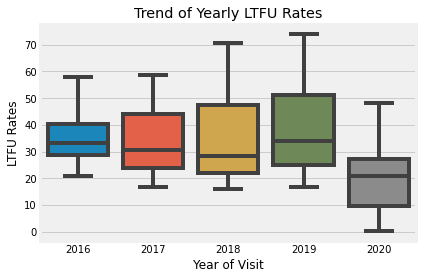

In [77]:
ax = sns.boxplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[df_ltfu['EF_YEAR_DATE_VISIT'] > 2015])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

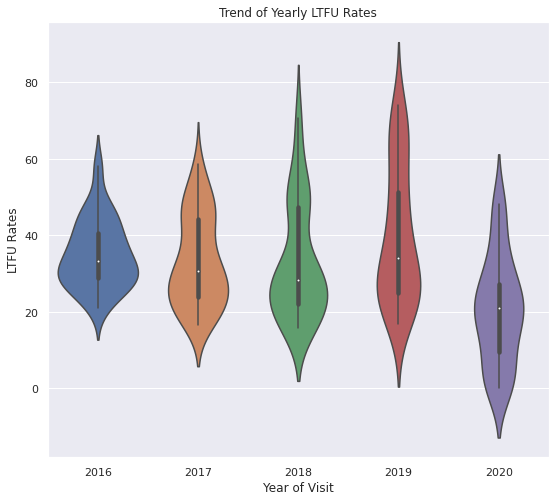

In [78]:
ax = sns.violinplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[df_ltfu['EF_YEAR_DATE_VISIT'] > 2015])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

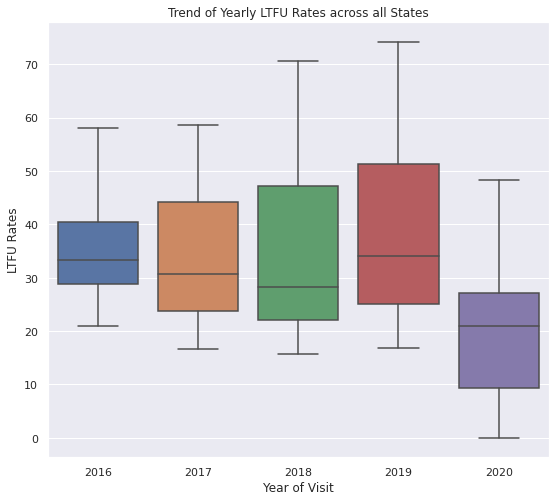

In [79]:
ax = sns.boxplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[df_ltfu['EF_YEAR_DATE_VISIT'] > 2015])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates across all States')
sns.set(rc={'figure.figsize':(8,8)})

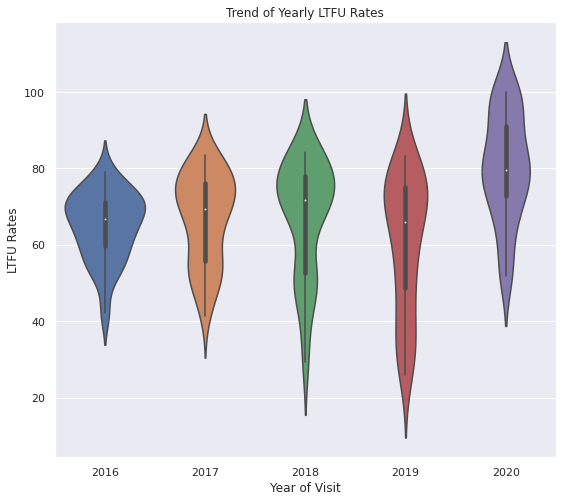

In [80]:
ax = sns.violinplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=df_ltfu_not[df_ltfu_not['EF_YEAR_DATE_VISIT'] > 2015])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

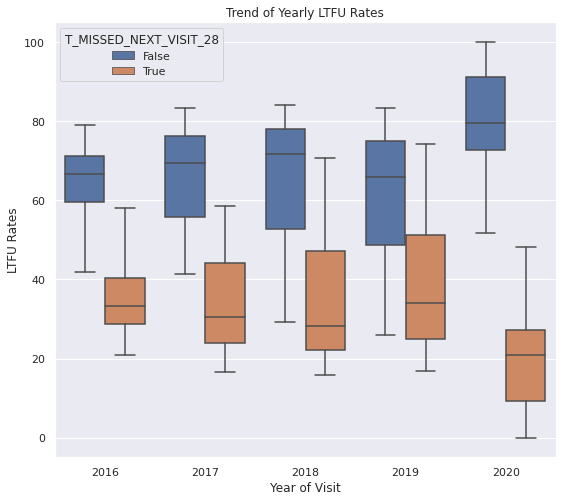

In [81]:
ax = sns.boxplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=ltfu_rates[ltfu_rates['EF_YEAR_DATE_VISIT'] > 2015],hue="T_MISSED_NEXT_VISIT_28")
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

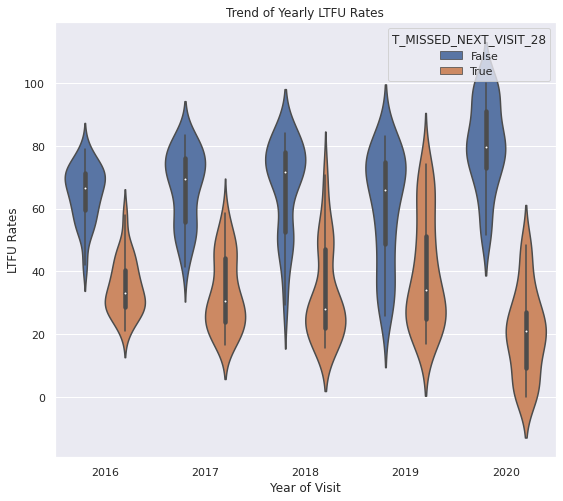

In [82]:
ax = sns.violinplot(x="EF_YEAR_DATE_VISIT",y="LTFU_RATES_PERCENTAGE",data=ltfu_rates[ltfu_rates['EF_YEAR_DATE_VISIT'] > 2015],hue="T_MISSED_NEXT_VISIT_28")
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates')
sns.set(rc={'figure.figsize':(8,8)})

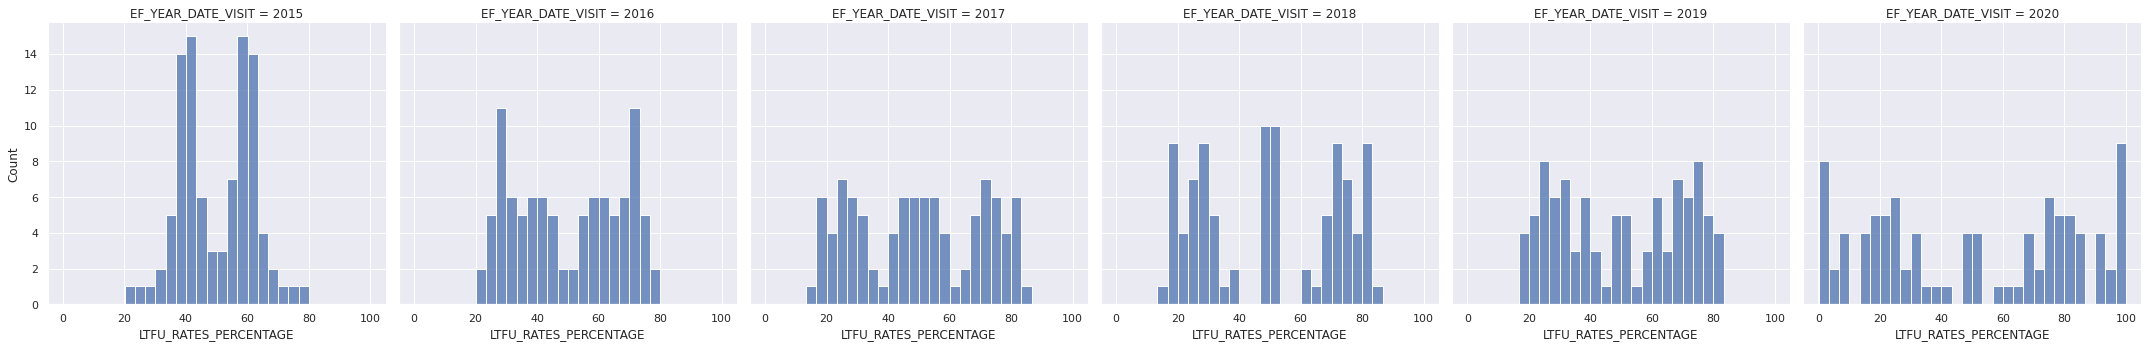

In [83]:
sns.displot(ltfu_rates,x="LTFU_RATES_PERCENTAGE",col="EF_YEAR_DATE_VISIT",bins=30)
sns.set(rc={'figure.figsize':(8,8)})

## Geographical trend

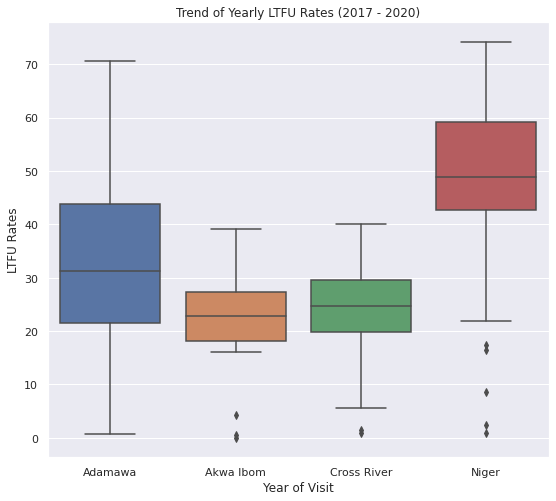

In [84]:
ax = sns.boxplot(x="State",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)]) 
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2017 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

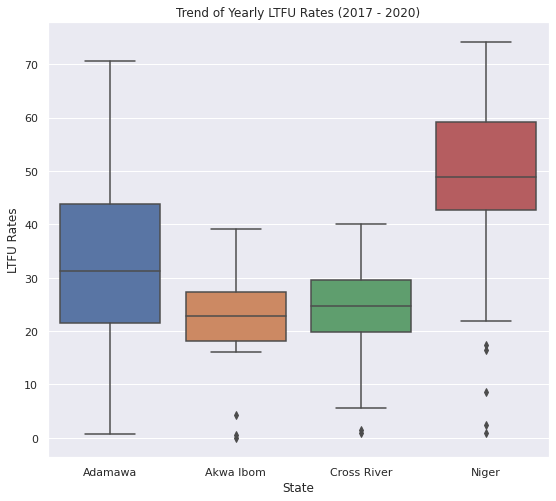

In [85]:
ax1 = sns.boxplot(x="State",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)]) 
ax1.set(xlabel='State', ylabel='LTFU Rates')
ax1.set_title('Trend of Yearly LTFU Rates (2017 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

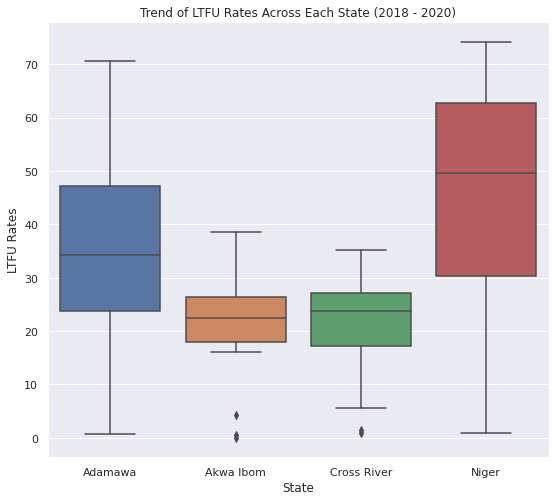

In [86]:
ax = sns.boxplot(x="State",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2017) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='State', ylabel='LTFU Rates')
ax.set_title('Trend of LTFU Rates Across Each State (2018 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

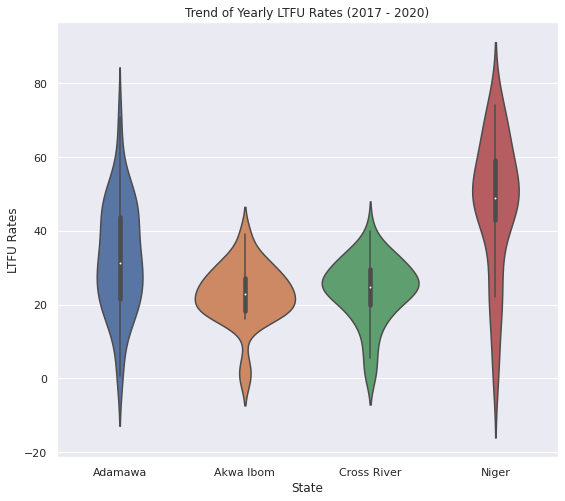

In [87]:
ax = sns.violinplot(x="State",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='State', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2017 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

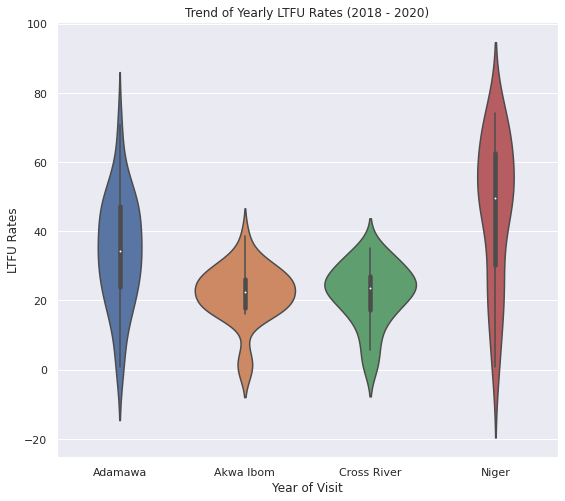

In [88]:
ax = sns.violinplot(x="State",y="LTFU_RATES_PERCENTAGE",data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2017) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)])
ax.set(xlabel='Year of Visit', ylabel='LTFU Rates')
ax.set_title('Trend of Yearly LTFU Rates (2018 - 2020)')
sns.set(rc={'figure.figsize':(8,8)})

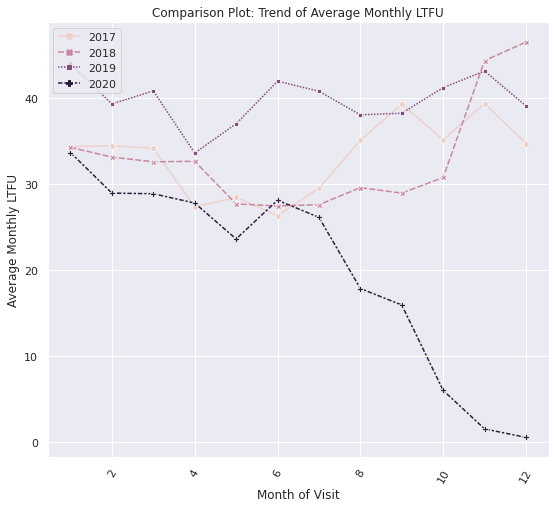

In [89]:
ax_viral = sns.lineplot(x = 'EF_MONTH_DATE_VISIT',y='LTFU_RATES_PERCENTAGE',data=df_ltfu[(df_ltfu['EF_YEAR_DATE_VISIT'] > 2016) & (df_ltfu['EF_YEAR_DATE_VISIT'] < 2021)],hue='EF_YEAR_DATE_VISIT',markers=True,err_style="bars",ci=None,style="EF_YEAR_DATE_VISIT")
ax_viral.set(xlabel='Month of Visit', ylabel='Average Monthly LTFU')
ax_viral.set_title('Comparison Plot: Trend of Average Monthly LTFU')
plt.xticks(rotation=60)
plt.legend(loc='upper left')
sns.set(rc={'figure.figsize':(10,10)})